In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [2]:
import yfinance as yf

In [3]:
#Download Tata motors data from yahoo finance
df = yf.download('ITC.NS')

[*********************100%***********************]  1 of 1 completed


In [4]:
#first 5 samples
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,5.550000,5.600000,5.533333,5.583333,3.303552,985500
1996-01-02,5.466666,5.566666,5.288888,5.372222,3.178643,7470000
1996-01-03,5.133333,5.254444,5.101111,5.200000,3.076742,15160500
1996-01-04,5.200000,5.332222,5.144444,5.297777,3.134595,12397500
1996-01-05,5.297777,5.277777,5.188888,5.202222,3.078056,5008500


In [5]:
# to check dates in index
df.index

DatetimeIndex(['1996-01-01', '1996-01-02', '1996-01-03', '1996-01-04',
               '1996-01-05', '1996-01-08', '1996-01-09', '1996-01-10',
               '1996-01-11', '1996-01-12',
               ...
               '2023-06-15', '2023-06-16', '2023-06-19', '2023-06-20',
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-26',
               '2023-06-27', '2023-06-30'],
              dtype='datetime64[ns]', name='Date', length=6910, freq=None)

In [6]:
df.shape

(6910, 6)

In [7]:
# to check features or columns 
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-22,448.000000,449.649994,445.850006,447.649994,447.649994,6637099
2023-06-23,447.500000,447.649994,442.700012,444.750000,444.750000,6090901
2023-06-26,446.899994,451.399994,444.000000,445.700012,445.700012,5477339
2023-06-27,446.100006,447.200012,443.149994,445.100006,445.100006,4865596
2023-06-30,450.000000,451.950012,446.600006,451.600006,451.600006,9105041


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6910 entries, 1996-01-01 to 2023-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6910 non-null   float64
 1   High       6910 non-null   float64
 2   Low        6910 non-null   float64
 3   Close      6910 non-null   float64
 4   Adj Close  6910 non-null   float64
 5   Volume     6910 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 377.9 KB


In [10]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

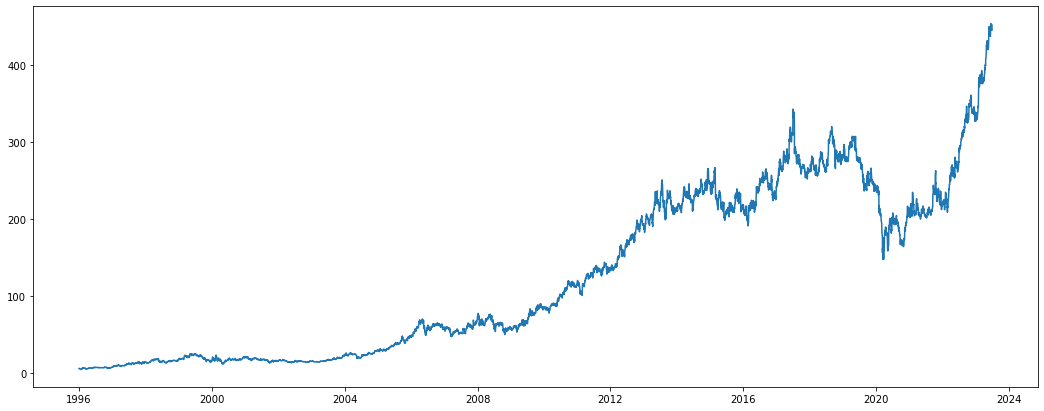

In [12]:
# plot a graph
plt1 = plt.figure(figsize=(18,7))
import matplotlib.pyplot as plt
plt.plot(df['Close'])

In [13]:
# check open price for first day and close price for last day
print("Starting price: ",df.iloc[0][0])
print("Ending price: ", df.iloc[-1][3])

Starting price:  5.550000190734863
Ending price:  451.6000061035156


In [14]:
# check start date and end date in our dataset
print("Starting date: ",df.index[0])
print("Ending date: ", df.index[-1])

Starting date:  1996-01-01 00:00:00
Ending date:  2023-06-30 00:00:00


In [15]:
# drop some columns except 'close ' columns as we are going to do prediction only on closing price
df.drop(columns=['High','Low','Adj Close','Volume'],inplace=True)

In [16]:
df.head()

,Open,Close
Date,,
1996-01-01,5.550000,5.583333
1996-01-02,5.466666,5.372222
1996-01-03,5.133333,5.200000
1996-01-04,5.200000,5.297777
1996-01-05,5.297777,5.202222


In [17]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
# Preprocess the data
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df['Close']).reshape(-1,1))

In [18]:
df1

array([[0.00311761],
       [0.00264787],
       [0.00226466],
       ...,
       [0.98242171],
       [0.98108664],
       [0.9955498 ]])

In [19]:
# Split data into training and testing sets
train_size=int(len(df1)*0.7)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

In [20]:
train_size,test_size

(4837, 2073)

In [21]:
train_data

array([[0.00311761],
       [0.00264787],
       [0.00226466],
       ...,
       [0.52568261],
       [0.53369298],
       [0.53599224]])

In [22]:
# convert an array of values into a dataset matrix
#function to create new dataset which is required by LSTM.giving sequence of data to our LSTM model
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), numpy.array(dataY)

In [23]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
import numpy
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
X_train

array([[3.11761389e-03, 2.64787042e-03, 2.26465876e-03, ...,
        9.64204246e-05, 0.00000000e+00, 0.00000000e+00],
       [2.64787042e-03, 2.26465876e-03, 2.48222328e-03, ...,
        0.00000000e+00, 0.00000000e+00, 5.21661914e-04],
       [2.26465876e-03, 2.48222328e-03, 2.26960307e-03, ...,
        0.00000000e+00, 5.21661914e-04, 1.13480206e-03],
       ...,
       [5.35324700e-01, 5.37030636e-01, 5.39181551e-01, ...,
        5.24940918e-01, 5.28130232e-01, 5.39849088e-01],
       [5.37030636e-01, 5.39181551e-01, 5.25089256e-01, ...,
        5.28130232e-01, 5.39849088e-01, 5.37401464e-01],
       [5.39181551e-01, 5.25089256e-01, 5.15150453e-01, ...,
        5.39849088e-01, 5.37401464e-01, 5.25682607e-01]])

In [25]:
y_train

array([5.21661914e-04, 1.13480206e-03, 7.44171810e-04, ...,
       5.37401464e-01, 5.25682607e-01, 5.33692985e-01])

In [26]:
X_test

array([[0.53792066, 0.5447443 , 0.53643725, ..., 0.49734964, 0.50135483,
        0.50432162],
       [0.5447443 , 0.53643725, 0.53940408, ..., 0.50135483, 0.50432162,
        0.49260277],
       [0.53643725, 0.53940408, 0.54125831, ..., 0.50432162, 0.49260277,
        0.49289944],
       ...,
       [0.97774899, 0.98998705, 0.9917671 , ..., 0.99833117, 0.98542555,
        0.98676062],
       [0.98998705, 0.9917671 , 0.98197667, ..., 0.98542555, 0.98676062,
        0.98030784],
       [0.9917671 , 0.98197667, 0.96907111, ..., 0.98676062, 0.98030784,
        0.98242171]])

In [27]:
print(X_train.shape) 

(4816, 20)


In [28]:
print(y_train.shape)

(4816,)


In [29]:
print(X_test.shape)

(2052, 20)


In [30]:
print(ytest.shape)

(2052,)


In [31]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [32]:
X_train.shape

(4816, 20, 1)

In [33]:
X_train

array([[[3.11761389e-03],
        [2.64787042e-03],
        [2.26465876e-03],
        ...,
        [9.64204246e-05],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[2.64787042e-03],
        [2.26465876e-03],
        [2.48222328e-03],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [5.21661914e-04]],

       [[2.26465876e-03],
        [2.48222328e-03],
        [2.26960307e-03],
        ...,
        [0.00000000e+00],
        [5.21661914e-04],
        [1.13480206e-03]],

       ...,

       [[5.35324700e-01],
        [5.37030636e-01],
        [5.39181551e-01],
        ...,
        [5.24940918e-01],
        [5.28130232e-01],
        [5.39849088e-01]],

       [[5.37030636e-01],
        [5.39181551e-01],
        [5.25089256e-01],
        ...,
        [5.28130232e-01],
        [5.39849088e-01],
        [5.37401464e-01]],

       [[5.39181551e-01],
        [5.25089256e-01],
        [5.15150453e-01],
        ...,
        [5.39849088e-01],
        [5.3740

In [34]:
### Create the Stacked LSTM model
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model

In [35]:
#model=Sequential()
#model.add(LSTM(100, input_shape = (time_step , 1)))
#model.add(Dropout(0.2))
#model.add(LSTM(200, input_shape=(time_step , 1), return_sequences=False))
#model.add(Dropout(0.5))
#model.add(Dense(100,kernel_initializer='uniform',activation='sigmoid'))        
#model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))
#model.compile(loss='mse',optimizer='adam')

model=Sequential()
model.add(LSTM(50,input_shape=(time_step,1)))
model.add(Dropout(0.2))
#model.add(LSTM(50,return_sequences=True))
#model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
151/151 [==============================] - 8s 25ms/step - loss: 0.0029 - val_loss: 4.2636e-04
Epoch 2/100
151/151 [==============================] - 3s 20ms/step - loss: 4.3763e-04 - val_loss: 5.0752e-04
Epoch 3/100
151/151 [==============================] - 3s 19ms/step - loss: 3.8540e-04 - val_loss: 3.9277e-04
Epoch 4/100
151/151 [==============================] - 3s 18ms/step - loss: 3.0807e-04 - val_loss: 3.8615e-04
Epoch 5/100
151/151 [==============================] - 3s 18ms/step - loss: 2.7264e-04 - val_loss: 0.0011
Epoch 6/100
151/151 [==============================] - 3s 18ms/step - loss: 2.9112e-04 - val_loss: 0.0014
Epoch 7/100
151/151 [==============================] - 3s 18ms/step - loss: 2.3807e-04 - val_loss: 4.2681e-04
Epoch 8/100
151/151 [==============================] - 3s 19ms/step - loss: 2.2972e-04 - val_loss: 3.1073e-04
Epoch 9/100
151/151 [==============================] - 3s 20ms/step - loss: 2.1289e-04 - val_loss: 8.1325e-04
Epoch 10/100
151/151 [

Epoch 75/100
151/151 [==============================] - 3s 19ms/step - loss: 1.4709e-04 - val_loss: 1.1001e-04
Epoch 76/100
151/151 [==============================] - 3s 20ms/step - loss: 1.5102e-04 - val_loss: 1.5088e-04
Epoch 77/100
151/151 [==============================] - 3s 18ms/step - loss: 1.4559e-04 - val_loss: 1.2046e-04
Epoch 78/100
151/151 [==============================] - 3s 17ms/step - loss: 1.5105e-04 - val_loss: 1.5238e-04
Epoch 79/100
151/151 [==============================] - 3s 17ms/step - loss: 1.5641e-04 - val_loss: 2.0110e-04
Epoch 80/100
151/151 [==============================] - 3s 18ms/step - loss: 1.5831e-04 - val_loss: 1.1322e-04
Epoch 81/100
151/151 [==============================] - 3s 18ms/step - loss: 1.4798e-04 - val_loss: 1.9139e-04
Epoch 82/100
151/151 [==============================] - 3s 19ms/step - loss: 1.5412e-04 - val_loss: 1.1450e-04
Epoch 83/100
151/151 [==============================] - 3s 19ms/step - loss: 1.6903e-04 - val_loss: 2.0282e-04
E

In [38]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

65/65 [==============================] - 0s 7ms/step


In [39]:
train_predict

array([[0.00268739],
       [0.00290552],
       [0.00343214],
       ...,
       [0.51948583],
       [0.5238511 ],
       [0.5191283 ]], dtype=float32)

In [40]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [41]:
train_predict

array([[  5.3899846],
       [  5.4880133],
       [  5.7246866],
       ...,
       [237.6484   ],
       [239.61023  ],
       [237.48773  ]], dtype=float32)

In [42]:
test_predict

array([[220.88069],
       [219.34698],
       [219.03836],
       ...,
       [431.1413 ],
       [428.89987],
       [428.48248]], dtype=float32)

In [43]:
ytest

array([0.49260277, 0.49289944, 0.49238024, ..., 0.98030784, 0.98242171,
       0.98108664])

In [44]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


93.5402698211061

In [45]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

252.90073314768398

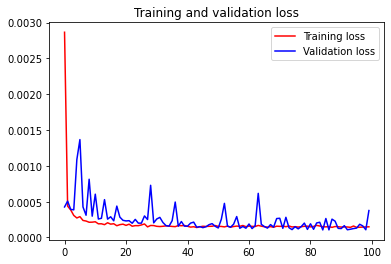

<Figure size 432x288 with 0 Axes>

In [46]:
### plot a graph for training and validation loss to visualize the results of model training

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.figure()


plt.show()

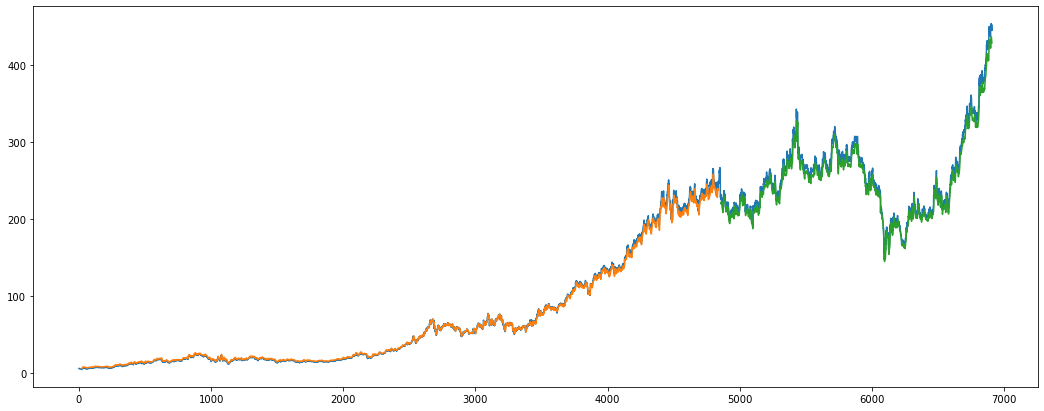

In [47]:
# shift train predictions for plotting
look_back=20
trainPredictPlot = numpy.empty_like(df1)  ## to take same shape and sata type of df1
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt1 = plt.figure(figsize=(18,7))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [48]:
ytest

array([0.49260277, 0.49289944, 0.49238024, ..., 0.98030784, 0.98242171,
       0.98108664])

In [49]:
test_predict

array([[220.88069],
       [219.34698],
       [219.03836],
       ...,
       [431.1413 ],
       [428.89987],
       [428.48248]], dtype=float32)

In [50]:
test_predict1 = test_predict.flatten()

In [51]:
len(ytest)

2052

In [52]:
test_predict1

array([220.88069, 219.34698, 219.03836, ..., 431.1413 , 428.89987,
       428.48248], dtype=float32)

In [53]:
ytest1 = ytest.flatten()

In [54]:
ytest1 = ytest1.reshape(1,-1)

In [55]:
ytest1

array([[0.49260277, 0.49289944, 0.49238024, ..., 0.98030784, 0.98242171,
        0.98108664]])

In [56]:
ytest2 = scaler.inverse_transform(ytest1)

In [57]:
ytest2

array([[225.56666565, 225.69999695, 225.46665955, ..., 444.75      ,
        445.70001221, 445.1000061 ]])

In [58]:
ytest2 = ytest2.flatten()

In [59]:
len(ytest2)

2052

In [60]:
df2 = df.iloc[4858:,:]

In [61]:
len(df2)

2052

In [62]:
df2.head()

,Open,Close
Date,,
2015-03-10,226.666672,225.699997
2015-03-11,226.899994,225.466660
2015-03-12,226.033340,231.100006
2015-03-13,232.199997,226.266663
2015-03-16,227.333328,223.600006


In [63]:
df2['predicted'] = test_predict1

In [64]:
df2.head(20)

,Open,Close,predicted
Date,,,
2015-03-10,226.666672,225.699997,220.880692
2015-03-11,226.899994,225.466660,219.346985
2015-03-12,226.033340,231.100006,219.038361
2015-03-13,232.199997,226.266663,219.136841
2015-03-16,227.333328,223.600006,222.319901
2015-03-17,226.333328,226.666672,221.970596
2015-03-18,227.500000,224.433334,220.044525
2015-03-19,225.666672,222.233337,220.274551
2015-03-20,222.466660,218.300003,219.449799


In [65]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2052 entries, 2015-03-10 to 2023-06-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2052 non-null   float64
 1   Close      2052 non-null   float64
 2   predicted  2052 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 56.1 KB


In [66]:
df2.tail()

,Open,Close,predicted
Date,,,
2023-06-22,448.000000,447.649994,436.186676
2023-06-23,447.500000,444.750000,432.715240
2023-06-26,446.899994,445.700012,431.141296
2023-06-27,446.100006,445.100006,428.899872
2023-06-30,450.000000,451.600006,428.482483


In [67]:
df2['temp_signal'] = df2['predicted'] - df2['Close']

In [68]:
df2.head()

,Open,Close,predicted,temp_signal
Date,,,,
2015-03-10,226.666672,225.699997,220.880692,-4.819305
2015-03-11,226.899994,225.466660,219.346985,-6.119675
2015-03-12,226.033340,231.100006,219.038361,-12.061646
2015-03-13,232.199997,226.266663,219.136841,-7.129822
2015-03-16,227.333328,223.600006,222.319901,-1.280106


In [69]:
df2['signal'] = df2['temp_signal'].apply(lambda x:1 if x>0 else 0)

In [70]:
df2.head()

,Open,Close,predicted,temp_signal,signal
Date,,,,,
2015-03-10,226.666672,225.699997,220.880692,-4.819305,0
2015-03-11,226.899994,225.466660,219.346985,-6.119675,0
2015-03-12,226.033340,231.100006,219.038361,-12.061646,0
2015-03-13,232.199997,226.266663,219.136841,-7.129822,0
2015-03-16,227.333328,223.600006,222.319901,-1.280106,0


In [71]:
df2.drop(columns='temp_signal',inplace = True)

In [72]:
df2.head()

,Open,Close,predicted,signal
Date,,,,
2015-03-10,226.666672,225.699997,220.880692,0
2015-03-11,226.899994,225.466660,219.346985,0
2015-03-12,226.033340,231.100006,219.038361,0
2015-03-13,232.199997,226.266663,219.136841,0
2015-03-16,227.333328,223.600006,222.319901,0


In [73]:
signal = list(df2['signal'])

In [74]:
signal

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [75]:
signal.insert(0,999)

In [76]:
signal

[999,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

In [77]:
len(df2)

2052

In [78]:
len(signal)

2053

In [79]:
signal.pop()

0

In [80]:
len(signal)

2052

In [81]:
new_signal = np.array(signal)

In [82]:
new_signal

array([999,   0,   0, ...,   0,   0,   0])

In [83]:
df2['new_signal'] = new_signal

In [84]:
df2.head()

,Open,Close,predicted,signal,new_signal
Date,,,,,
2015-03-10,226.666672,225.699997,220.880692,0,999
2015-03-11,226.899994,225.466660,219.346985,0,0
2015-03-12,226.033340,231.100006,219.038361,0,0
2015-03-13,232.199997,226.266663,219.136841,0,0
2015-03-16,227.333328,223.600006,222.319901,0,0


In [85]:
df2.drop(columns = 'signal',inplace = True)

In [86]:
df3 = df2[df2['new_signal']==1]

In [87]:
df3.head()

,Open,Close,predicted,new_signal
Date,,,,
2015-03-23,217.566666,218.266663,217.829239,1
2015-03-30,213.100006,218.366669,210.541748,1
2015-04-21,227.899994,227.966660,228.912582,1
2015-04-22,226.666672,228.933334,225.332932,1
2015-04-30,218.533340,214.899994,221.902557,1


In [88]:
df3['profit_loss'] = df3['Close'] - df3['Open']

In [89]:
df3.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2015-03-23,217.566666,218.266663,217.829239,1,0.699997
2015-03-30,213.100006,218.366669,210.541748,1,5.266663
2015-04-21,227.899994,227.966660,228.912582,1,0.066666
2015-04-22,226.666672,228.933334,225.332932,1,2.266663
2015-04-30,218.533340,214.899994,221.902557,1,-3.633347


In [90]:
df3['profit_loss'].sum()

-41.91676330566406

In [91]:
df4 = df2[df2['new_signal']==0]

In [92]:
df4['profit_loss'] = df4['Open'] - df4['Close']

In [93]:
df4.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2015-03-11,226.899994,225.466660,219.346985,0,1.433334
2015-03-12,226.033340,231.100006,219.038361,0,-5.066666
2015-03-13,232.199997,226.266663,219.136841,0,5.933334
2015-03-16,227.333328,223.600006,222.319901,0,3.733322
2015-03-17,226.333328,226.666672,221.970596,0,-0.333344


In [94]:
df2.head()

,Open,Close,predicted,new_signal
Date,,,,
2015-03-10,226.666672,225.699997,220.880692,999
2015-03-11,226.899994,225.466660,219.346985,0
2015-03-12,226.033340,231.100006,219.038361,0
2015-03-13,232.199997,226.266663,219.136841,0
2015-03-16,227.333328,223.600006,222.319901,0


In [95]:
df2.tail()

,Open,Close,predicted,new_signal
Date,,,,
2023-06-22,448.000000,447.649994,436.186676,0
2023-06-23,447.500000,444.750000,432.715240,0
2023-06-26,446.899994,445.700012,431.141296,0
2023-06-27,446.100006,445.100006,428.899872,0
2023-06-30,450.000000,451.600006,428.482483,0


In [96]:
df4['profit_loss'].sum()

428.46702575683594

In [97]:
Total_profit = df4['profit_loss'].sum() + df3['profit_loss'].sum()

In [98]:
Total_profit

386.5502624511719

In [99]:
# check open price for first day and close price for last day
print("Starting price: ",df2.iloc[0][0])
print("Ending price: ", df2.iloc[-1][2])

Starting price:  226.6666717529297
Ending price:  428.48248291015625


In [100]:
# total profit if buy and hold

buy_hold_profit = df2.iloc[-1][2] - df2.iloc[0][0]
buy_hold_profit

201.81581115722656

In [101]:
# excess profit generated by algo model

excess_profit = Total_profit - buy_hold_profit
excess_profit

184.7344512939453

In [102]:
# excess profit in percent

excess_profit_percent = (excess_profit *100)/Total_profit
excess_profit_percent

47.790538317712446

In [103]:
len(df3)

186

In [104]:
len(df4)

1865

In [105]:
len(df2)

2052